In [51]:
import matplotlib.pyplot as plt
from numpy import array
from pickle import dump
from __future__ import print_function
from keras.callbacks import LambdaCallback, EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
import tensorflow as tf
import string

In [20]:
# load text to memory
def load_doc(filename): 
# open the file as read only
    file = open(filename, 'r')
# read all text
    text = file.read()
# close the file
    file.close()
    return text

In [21]:

##heuristics for splitting up words
#replace dashes with a white space
#otherwise words based on white space.
#reduce all words to lowercase and remove punctuation from words 
#remove all words that are not alphabetic 
# turn a doc into clean tokens



def clean_doc(doc):
# replace '--' with a space ' '
    doc = doc.replace('--', ' ')
# split into tokens by white space
    tokens = doc.split()
# remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
# remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
# make lower case
    tokens = [word.lower() for word in tokens]
    return tokens


In [22]:
# use GPU to speed up training time through tensforflow
config = tf.ConfigProto()
#only allocate as much GPU memory based on runtime allocations, initially little but allows memory to be extended
config.gpu_options.allow_growth = True


In [23]:
# save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()


In [24]:
# load document
in_filename = '/Users/neilwatt/Documents/BIs/PrWeb/2018Posts/October/canterburytales.txt'
doc = load_doc(in_filename)
print(doc[:200])

The Project Gutenberg Etext of The Canterbury Tales and Other Poems
by Geoffrey Chaucer






                      THE CANTERBURY TALES
                         And other Poems
                      


In [25]:
# clean document
tokens = clean_doc(doc)
print(tokens[:200])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))


['the', 'project', 'gutenberg', 'etext', 'of', 'the', 'canterbury', 'tales', 'and', 'other', 'poems', 'by', 'geoffrey', 'chaucer', 'the', 'canterbury', 'tales', 'and', 'other', 'poems', 'of', 'geoffrey', 'chaucer', 'edited', 'for', 'popular', 'perusal', 'by', 'd', 'laing', 'purves', 'contents', 'preface', 'life', 'of', 'chaucer', 'the', 'canterbury', 'tales', 'the', 'general', 'prologue', 'the', 'knights', 'tale', 'the', 'millers', 'tale', 'the', 'reeves', 'tale', 'the', 'cooks', 'tale', 'the', 'man', 'of', 'laws', 'tale', 'the', 'wife', 'of', 'baths', 'tale', 'the', 'friars', 'tale', 'the', 'sompnours', 'tale', 'the', 'clerks', 'tale', 'the', 'merchants', 'tale', 'the', 'squires', 'tale', 'the', 'franklins', 'tale', 'the', 'doctors', 'tale', 'the', 'pardoners', 'tale', 'the', 'shipmans', 'tale', 'the', 'prioresss', 'tale', 'chaucers', 'tale', 'of', 'sir', 'thopas', 'chaucers', 'tale', 'of', 'meliboeus', 'the', 'monks', 'tale', 'the', 'nuns', 'priests', 'tale', 'the', 'second', 'nuns',

In [26]:
# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    # select sequence of tokens
    seq = tokens[i-length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 264697


In [27]:
# save sequences to file
out_filename = 'canterburytales_sequences.txt'
save_doc(sequences, out_filename)

In [28]:
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# load
in_filename = 'canterburytales_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

In [29]:
#representation of the model is distributed
#- i.e words with similar meaning have similar representation
#representation learned simulataneously with model
#probability of next word using context of last 100 words
#embedding layer for representation, LSTM to predict words on context

# integer encode sequences of words
#mapping each word to unique integer and encoding input sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

# vocabulary size
#i add a one since vocabulary begins from index one 
#but indexing arrays is zero offset
vocab_size = len(tokenizer.word_index) + 1

In [30]:

#need to seperate word encodings into  y (output) and x (input)
# separate output from input with array slicing
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

In [45]:

# defining model
# two LSTM hidden layers with 100 memory cells
#dense fully connected layer with 100 neurons connects to the LSTM hidden layers 
#to interpret the features extracted from the sequence
#output layer predicts the next word as a single vector the size of the vocabulary 
#with a probability for each word in the vocabulary
#softmax activation function is used to ensure 
#the outputs have the characteristics of normalized probabilities
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
#model.add(LSTM(100))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
#model.add(Dense(100))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 50)            885650    
_________________________________________________________________
lstm_12 (LSTM)               (None, 50, 100)           60400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 17713)             1789013   
Total params: 2,825,563
Trainable params: 2,825,563
Non-trainable params: 0
_________________________________________________________________
None


In [46]:

# compile model
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [48]:
# define the checkpoint so I can load model in future
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                 
                             mode='min')
earlystop = EarlyStopping(monitor='val_loss', patience=2,
                              verbose=2)

# fit model using the gpu
#batch size is a particularly important hyperparamter which I intend to play around within future posts
with tf.device('/gpu:0'):

    history=model.fit(X, y,validation_split=0.1,batch_size=128,epochs=60,verbose=2,callbacks=[ checkpoint,earlystop])


Train on 238227 samples, validate on 26470 samples
Epoch 1/60
 - 8361s - loss: 6.8777 - acc: 0.0648 - val_loss: 7.1209 - val_acc: 0.0810

Epoch 00001: loss improved from inf to 6.87773, saving model to weights.hdf5
Epoch 2/60
 - 3026s - loss: 7.0025 - acc: 0.0837 - val_loss: 7.4118 - val_acc: 0.0857

Epoch 00002: loss did not improve from 6.87773
Epoch 3/60
 - 10235s - loss: 7.0726 - acc: 0.0896 - val_loss: 7.4012 - val_acc: 0.0750

Epoch 00003: loss did not improve from 6.87773
Epoch 00003: early stopping


In [49]:
print(history.history.keys())

dict_keys(['val_loss', 'acc', 'val_acc', 'loss'])


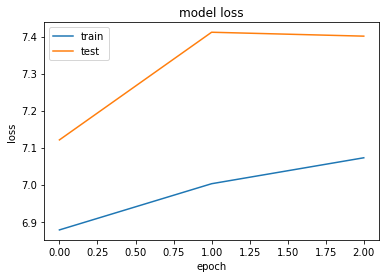

In [52]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [ ]:
from random import randint
from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
 
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 


In [ ]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        yhat = model.predict_classes(encoded, verbose=0)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)
 
# load cleaned text sequences
in_filename = 'canterburytales.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
seq_length = len(lines[0].split()) - 1
 
# load the model
model = load_model('weights.hdf5')
 
# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
 
# select a seed text
seed_text = lines[randint(0,len(lines))]
print(seed_text + '\n')
 
# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
print(generated)